# A modular approach to modelling the MAPK cascade

The MAPK cascade is a biochemical network that regulates many biological processes including growth, proliferation, migration and differentiation. The system is composed of a cascade of phosphorylation events in which the phosphorylated substrate of one level of the cascade catalyses reactions on the next level, which can lead to an amplification of signal. From a modelling perspective, the MAPK cascade is interesting as it contains a number of repeated motifs, and therefore serves an example of describing models in a way that is reusable. The repeating nature of the system may also be useful in helping us to understand the roles of feedback in biochemical systems, and design in synthetic circuits.

This notebook describes a method for systematically constructing a model of the MAPK cascade, using bond graphs. Due to the presence of repeated network motifs, the approach taken here is to first construct generic models of kinases and phosphatases, which are then combined into a generic model of a generic phosphorylation cycle. Copies of this phosphorylation cycle are then  coupled together into a model of a full MAPK cascade.

Note that this notebook takes a "hard port" approach to model integration, in line with modelling approaches in engineering. However, the bond graph approach (and more generally, network thermodynamic approaches) is also compatible with the "soft port" approach that is increasingly favoured by systems biologists. The soft port approach is employed in a separate notebook.

In [ ]:
# This block of code is used to make the notebook work within Binder.
# It can be skipped or deleted for most other setups.
import julia
from julia import Julia
jl = Julia(compiled_modules=False)

In [1]:
import BondGraphTools as bgt
from BondGraphTools.reaction_builder import Reaction_Network
from BondGraphTools import BondGraph
import numpy as np
from matplotlib import pyplot as plt

import sys
import bgt_extensions as bgex
from bgt_extensions import Ce, Se, unify, promote
from general import mpl_settings, save_figure
from plot_options import set_color_palette
set_color_palette()

## Kinase

We begin by constructing a model of a generic kinase. The kinase is assumed to operate via the following Michaelis-Menten mechanism:
$$
    E + M + ATP \rightleftharpoons C \\
    C \rightleftharpoons E + MP + ADP
$$
where the (generic) species are defined as follows:
- E is the unbound kinase
- M is unbound substrate
- MP is the phosphorylated substrate
- ATP and ADP are defined as usual
- C is the kinase complexed with M and ATP

In order to incorporate the model of the kinase into a larger model, the species that interact with other parts of the MAPK cascade need to be modelled as external ports. Thus, in the modular version of the model, the species E, M, MP, ATP and ADP are external ports. 

In [2]:
affinity_ATP_hydrolysis = 50000/8.314/310

class Kinase(BondGraph):
    def __init__(self,name="Kinase",modular=True,K_M=1.0,K_E=1.0):
        kinase_reactions = [
            ("E + M + ATP = C","r1"),
            ("C = E + MP + ADP","r2")
        ]
        chemostats = ["ATP","ADP"]
        self.K_M = K_M
        self.K_E = K_E
        
        BondGraph.__init__(self,name=name)
        bgex.add_reactions(self,kinase_reactions,chemostats,normalised=True)
        
        if modular:
            bgex.expose(self/"SS:ATP","ATP")
            bgex.expose(self/"SS:ADP","ADP")
            bgex.expose(self/"C:E","E")
            bgex.expose(self/"C:M","M")
            bgex.expose(self/"C:MP","MP")
        
    @property
    def default_params(self):
        self.ATP_potential = affinity_ATP_hydrolysis
        self.ADP_potential = 0.0
        ATP_potential = self.ATP_potential
        
        a = 1000
        d = 150
        k = 150
        
        K_C = np.exp(ATP_potential)*d/a*self.K_M*self.K_E
        r1 = d/K_C
        r2 = k/K_C
        
        params = {
            ("C:E","k"): self.K_E,
            ("C:C","k"): K_C,
            ("C:M","k"): self.K_M,
            ("C:MP","k"): None,
            ("SS:ATP","e"): ATP_potential,
            ("SS:ADP","e"): self.ADP_potential,
            ("R:r1","r"): r1,
            ("R:r2","r"): r2
        }
        
        return params
        
    def set_params(self, params=None):
        if not params:
            params = self.default_params
        bgex.set_parameters(self,params)

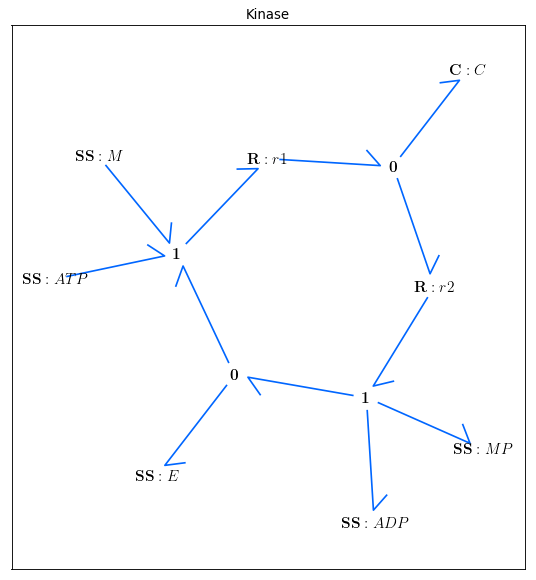

In [3]:
bgt.draw(Kinase())
plt.show()

## Phosphatase
A similar approach is taken for constructing a generic model of the phosphatase. The phosphatase is assumed to use the mechanism
$$
    E + MP \rightleftharpoons C \\
    C \rightleftharpoons E + M + P
$$
where the species are interpreted as follows:
- E is the unbound phosphatase
- M is the unbound substrate
- MP is the phosphorylated substrate
- P is the inorganic phosphate
- C is the phosphate complexed with MP

Note that while E and C have the same name as the kinase, they have different interpretations and are thus different components. The encapsulation of these components within separate modules allows these components to be treated as separate entities.

As with the kinase, the species E, M, MP and P are modelled using external ports to connect with other parts of the system.

In [4]:
class Phosphatase(BondGraph):
    def __init__(self,name="Phosphatase",modular=True,K_MP=1.0,K_E=1.0):
        phosphatase_reactions = [
            ("E + MP = C","r1"),
            ("C = E + M + P","r2")
        ]
        chemostats = ["P"]
        self.K_MP = K_MP
        self.K_E = K_E
        
        BondGraph.__init__(self,name=name)
        bgex.add_reactions(self,phosphatase_reactions,chemostats,normalised=True)
        
        if modular:
            bgex.expose(self/"C:E","E")
            bgex.expose(self/"C:M","M")
            bgex.expose(self/"C:MP","MP")
            bgex.expose(self/"SS:P","P")
        
    @property
    def default_params(self):
        self.P_potential = 0.0
        
        a = 1000
        d = 150
        k = 150
        K_C = d/a*self.K_MP*self.K_E
        r1 = d/K_C
        r2 = k/K_C
        
        params = {
            ("C:E","k"): self.K_E,
            ("C:C","k"): K_C,
            ("C:M","k"): None,
            ("C:MP","k"): self.K_MP,
            ("SS:P","e"): self.P_potential,
            ("R:r1","r"): r1,
            ("R:r2","r"): r2
        }
        return params
        
    def set_params(self,params=None):
        #self.P_potential = 0.0
        if not params:
            params = self.default_params
        bgex.set_parameters(self,params)

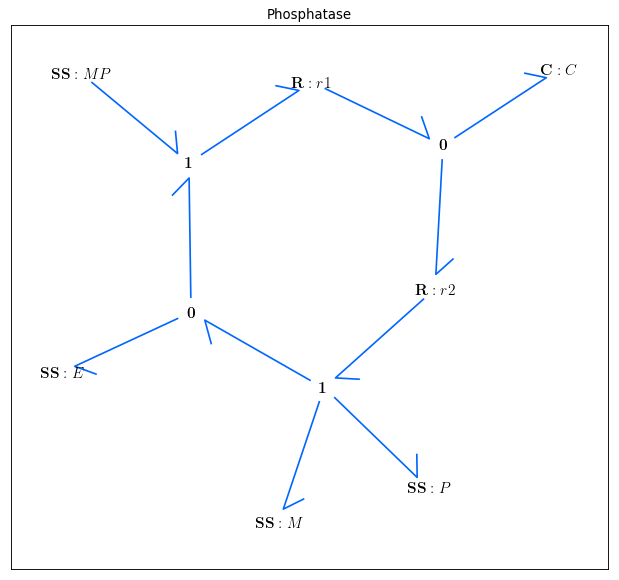

In [5]:
bgt.draw(Phosphatase())

## Phosphorylation cycle

The MAPK cascade consists of multiple phosphorylation cycles where a kinase and phosphatase operate in opposite directions. It has been hypothesised that energy-consuming cycles provide the cell with a means of controlling the phosphorylation of substrates. In the code below, we couple the above models of the kinase and phosphatase into a model of the phosphorylation cycle. To do this, the following operations are performed:
- The species M and MP are interpreted as the same component between the two modules. Thus they are linked together through a 0-junction.
- The free enzymes E within the kinase and phosphatase are interpreted as separate entities, and therefore link to separate ports - a "Kin" port for the kinase and a "Pho" port for the phosphatase.
- ATP, ADP and P have their own components
- Since M, MP, Kin, Pho, ATP, ADP and P are connected to other parts of the MAPK cascade, these components are exposed as external ports.

In [6]:
class PhosphorylationCycle(BondGraph):
    def __init__(self,name="Phosphorylation Cycle",modular=True,
                 K_M=1.0,K_MP=1.0,K_Kin=1.0):
        k = Kinase(K_M=K_M,K_E=K_Kin)
        p = Phosphatase(K_MP=K_MP)
        M = Ce(name="M")
        MP = Ce(name="MP")
        ATP = Se(name="ATP")
        ADP = Se(name="ADP")
        P = Se(name="P")
        Kin = Ce(name="Kin")
        Pho = Ce(name="Pho")
        M_junc = bgt.new("0",name="M")
        MP_junc = bgt.new("0",name="MP")
        
        BondGraph.__init__(self,name=name,
                           components=(k,p,M,MP,M_junc,MP_junc,ATP,ADP,P,Kin,Pho))
        
        self.kinase = k
        self.phosphatase = p
        self.K_M = K_M
        self.K_MP = K_MP
        self.K_Kin = K_Kin
        
        bgt.connect(M_junc,M)
        bgt.connect(MP_junc,MP)
        bgt.connect(M_junc,(k,"M"))
        bgt.connect((k,"MP"),MP_junc)
        bgt.connect(MP_junc,(p,"MP"))
        bgt.connect((p,"M"),M_junc)
        bgt.connect((k,"ATP"),ATP)
        bgt.connect((k,"ADP"),ADP)
        bgt.connect((p,"P"),P)
        bgt.connect((k,"E"),Kin)
        bgt.connect((p,"E"),Pho)
        
        if modular:
            bgex.expose(Kin,"Kin")
            bgex.expose(Pho,"Pho")
            bgex.expose(M,"M")
            bgex.expose(MP,"MP")
            bgex.expose(ATP,"ATP")
            bgex.expose(ADP,"ADP")
            bgex.expose(P,"P")
        
        bgex.set_aqueous_solution_parameters(self,R=1.0,T=1.0)
        
    @property
    def default_params(self):
        params = {
            ("C:M","k"): self.K_M,
            ("C:MP","k"): self.K_MP,
            ("C:Kin","k"): self.K_Kin,
            ("C:Pho","k"): self.phosphatase.default_params[("C:E","k")],
            ("SS:ATP","e"): self.kinase.default_params[("SS:ATP","e")],
            ("SS:ADP","e"): self.kinase.default_params[("SS:ADP","e")],
            ("SS:P","e"): self.phosphatase.default_params[("SS:P","e")],
        }
        
        return params
        
    def set_params(self, params=None):
        self.kinase.set_params()
        self.phosphatase.set_params()
        
        if not params:
            params = self.default_params
        bgex.set_parameters(self,params)

## MAPK pathway
Separate copies of the model of the phosphorylation cycle below can be coupled together into a model of the MAPK cascade. The resulting bond graph is shown in the diagram below (insert figure).

In [7]:
class MAPK(BondGraph):
    def __init__(self,name="MAPK",input_flow=False):
        BondGraph.__init__(self,name=name)
        
        species = [
            "MKKKK","MKKK","MKKKP","MKK","MKKP","MKKPP","MK","MKP","MKPP",
            "MAPKKK-Pase","MAPKK-Pase","MAPK-Pase"
        ]
        self.species = species
        for s in species:
            storage = Ce(name=s,value={"R":1,"T":1})
            junction = bgt.new("0",name=s)
            bgt.add(self,storage,junction)
            bgt.connect(junction,storage)

        chemostats = ["ATP","ADP","P"]
        for c in chemostats:
            source = bgt.new("Se",name=c)
            junction = bgt.new("0",name=c)
            bgt.add(self,source,junction)
            bgt.connect(junction,source)

        a = 1000
        d = 150
        k = 150
        D = (a*k/d)**2*np.exp(-affinity_ATP_hydrolysis)
        
        K_MKKKK = 1.0
        K_MKKK = 1.0
        K_MKK = 1.0
        K_MK = 1.0
        K_MKKKPase = 1.0
        K_MKKPase = 1.0
        K_MKPase = 1.0
        
        P_factor = (np.sqrt(D)/k)*(d/a)*np.exp(affinity_ATP_hydrolysis)
        K_MKKKP = K_MKKK*P_factor
        K_MKKP = K_MKK*P_factor
        K_MKKPP = K_MKKP*P_factor
        K_MKP = K_MK*P_factor
        K_MKPP = K_MKP*P_factor
        
        Kdict = {
            "MKKKK": K_MKKKK,
            "MKKK": K_MKKK,
            "MKKKP": K_MKKKP,
            "MKK": K_MKK,
            "MKKP": K_MKKP,
            "MKKPP": K_MKKPP,
            "MK": K_MK,
            "MKP": K_MKP,
            "MKPP": K_MKPP,
            "MAPKKK-Pase": 1.0,
            "MAPKK-Pase": 1.0,
            "MAPK-Pase": 1.0,
        }
        self.default_affinities = Kdict
        
        phosphorylation_cycles = [
            ("Cycle1", "MKKKK", "MAPKKK-Pase", "MKKK", "MKKKP"),
            ("Cycle2", "MKKKP", "MAPKK-Pase", "MKK", "MKKP"),
            ("Cycle3", "MKKKP", "MAPKK-Pase", "MKKP", "MKKPP"),
            ("Cycle4", "MKKPP", "MAPK-Pase", "MK", "MKP"),
            ("Cycle5", "MKKPP", "MAPK-Pase", "MKP", "MKPP")
        ]
        
        self.cycles = []

        for name,kin,pho,s,p in phosphorylation_cycles:
            c = PhosphorylationCycle(
                name=name,
                K_M=Kdict[s],K_MP=Kdict[p],K_Kin=Kdict[kin]
            )
            self.cycles.append(c)
            bgt.add(self,c)
            bgt.connect((c,"Kin"),self/f"0:{kin}")
            bgt.connect((c,"Pho"),self/f"0:{pho}")
            bgt.connect((c,"M"),self/f"0:{s}")
            bgt.connect((c,"MP"),self/f"0:{p}")
            bgt.connect((c,"ATP"),self/"0:ATP")
            bgt.connect((c,"ADP"),self/"0:ADP")
            bgt.connect((c,"P"),self/"0:P")
            
        if input_flow:
            # Add flow source to MAPKKKK
            input_source = bgt.new("Sf",name="Input flow")
            bgt.add(self,input_source)
            bgt.connect(input_source,self/"0:MKKKK")
            
        bgex.set_aqueous_solution_parameters(self,R=1.0,T=1.0)
            
    @property
    def default_params(self):
        cycle1 = self.cycles[0]
        params = {
            ("SS:ATP","e"): cycle1.default_params[("SS:ATP","e")],
            ("SS:ADP","e"): cycle1.default_params[("SS:ADP","e")],
            ("SS:P","e"): cycle1.default_params[("SS:P","e")],
        }
        
        for s in self.species:
            params[(f"C:{s}","k")] = self.default_affinities[s]
        
        return params
    
    def set_params(self, params=None):
        for c in self.cycles:
            c.set_params()
        
        if not params:
            params = self.default_params
        bgex.set_parameters(self,params)

(The code below describes a static version of the MAPK model in case repeated simulations need to be run. This model avoids the need to recalculate the constitutive relations every time a simulation is run, but requires the modeller to call a specific function to make the equations update.)

In [8]:
class MAPK_Static(bgex.StaticBondGraph,MAPK):
    def __init__(self,name="MAPK",input_flow=False):
        MAPK.__init__(self,name,input_flow)

In the code below, we run a simulation of the system.

We fix parameters for some of the species, either using information known in the literature or by making assumptions about the system. The standard free energy of ATP hydrolysis is assumed to be -31 kJ/mol (or approximately -12RT) under physiological conditions. For now, we assume that the standard energy of formation of each of the MAPK molecules is zero.

In [9]:
from bgt_juliasim import simulate

# The function below allows initial conditions to be defined from a dictionary
def MAPK_ic(model,initial_conditions):
    n_states = len(model.state_vars)
    x0 = np.zeros(n_states)
    for i,(component,state_ref) in enumerate(model.state_vars.values()):
        name = component.name
        if name in initial_conditions.keys():
            x0[i] = initial_conditions[name]
            
    return x0

initial_conditions = {
    "MKKKK": 3e-5,
    "MKKK": 0.003,
    "MKK": 1.2,
    "MK": 1.2,
    "MAPKKK-Pase": 0.0003,
    "MAPKK-Pase": 0.0003,
    "MAPK-Pase": 0.12
}

model = MAPK_Static()
model.set_params()
model.update_constitutive_relations()
sol = simulate(model,(0.0,100.0),MAPK_ic(model,initial_conditions))

The relative amounts of components within the pathway are plotted below.

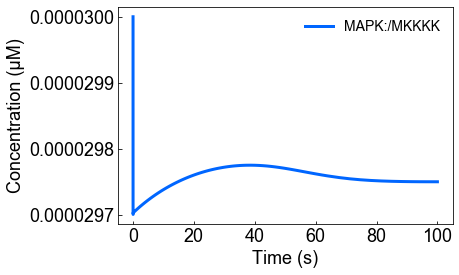

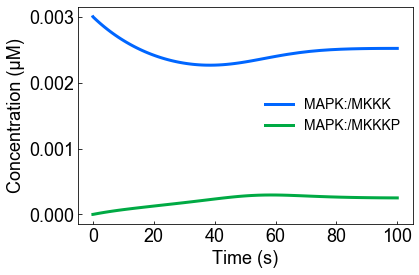

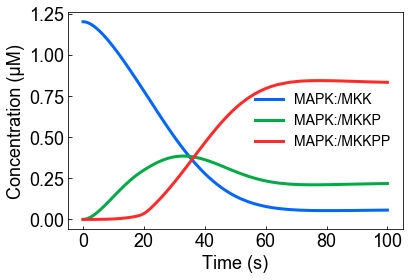

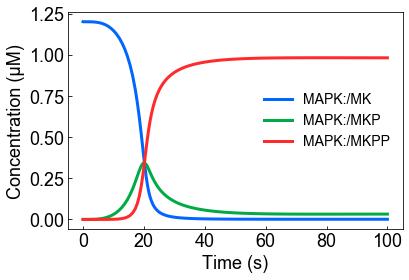

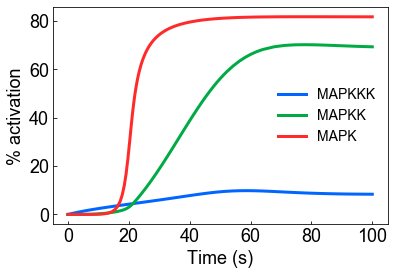

In [10]:
from bgt_extensions import plot_solution
mpl_settings()

def plot_kinases(sol,model):
    fig1 = plt.figure()
    plot_solution(sol,model,model/"C:MKKKK")
    plt.xlabel("Time (s)")
    plt.ylabel("Concentration (μM)")
    plt.legend(fontsize=14,frameon=False)

    fig2 = plt.figure()
    plot_solution(sol,model,model/"C:MKKK")
    plot_solution(sol,model,model/"C:MKKKP")
    plt.xlabel("Time (s)")
    plt.ylabel("Concentration (μM)")
    plt.legend(fontsize=14,frameon=False)

    fig3 = plt.figure()
    plot_solution(sol,model,model/"C:MKK")
    plot_solution(sol,model,model/"C:MKKP")
    plot_solution(sol,model,model/"C:MKKPP")
    plt.xlabel("Time (s)")
    plt.ylabel("Concentration (μM)")
    plt.legend(fontsize=14,frameon=False)

    fig4 = plt.figure()
    plot_solution(sol,model,model/"C:MK")
    plot_solution(sol,model,model/"C:MKP")
    plot_solution(sol,model,model/"C:MKPP")
    plt.xlabel("Time (s)")
    plt.ylabel("Concentration (μM)")
    plt.legend(fontsize=14,frameon=False)
    
    return fig1,fig2,fig3,fig4
    
def plot_activation(sol,model,
                    total_MKKK=0.003, total_MKK=1.2, total_MK=1.2):
    t = sol.t
    _,MKKKP = bgex.extract_solution_values(sol,model,model/"C:MKKKP")
    _,MKKPP = bgex.extract_solution_values(sol,model,model/"C:MKKPP")
    _,MKPP = bgex.extract_solution_values(sol,model,model/"C:MKPP")
    
    fig = plt.figure()
    plt.plot(t,100*MKKKP/total_MKKK,label="MAPKKK")
    plt.plot(t,100*MKKPP/total_MKK,label="MAPKK")
    plt.plot(t,100*MKPP/total_MK,label="MAPK")
    plt.xlabel("Time (s)")
    plt.ylabel("% activation")
    plt.legend(fontsize=14,frameon=False)
    
    return fig

plot_kinases(sol,model)
fig_activation = plot_activation(sol,model)

The multiple levels of the MAPK cascade can give rise to amplification and ultrasensitivity (switch-like behaviour). We examine this in the code below, which runs multiple simulations of the MAPK cascade with different initial amounts of the input kinase MAPKKKK. The concentrations of the active kinases MAPKKKP, MAPKKPP, MAPKPP are recorded at steady state.

In [11]:
model = MAPK_Static()
model.set_params()
model.update_constitutive_relations()

input_concentrations = np.logspace(-7,-1,num=100)

initial_conditions = {
    "MKKK": 0.003,
    "MKK": 1.2,
    "MK": 1.2,
    "MAPKKK-Pase": 0.0003,
    "MAPKK-Pase": 0.0003,
    "MAPK-Pase": 0.12
}

def simulate_ss_response(model,input_concentrations,initial_conditions,
                         sim_options={}):
    MKKKP = []
    MKKPP = []
    MKPP = []
    
    for c in input_concentrations:
        initial_conditions["MKKKK"] = c
        sol = simulate(model,(0.0,1000.0),MAPK_ic(model,initial_conditions),**sim_options)

        t,x = bgex.extract_solution_values(sol,model,model/"C:MKKKP")
        MKKKP.append(x[-1])

        t,x = bgex.extract_solution_values(sol,model,model/"C:MKKPP")
        MKKPP.append(x[-1])

        t,x = bgex.extract_solution_values(sol,model,model/"C:MKPP")
        MKPP.append(x[-1])
        
    return MKKKP, MKKPP, MKPP

MKKKP,MKKPP,MKPP = simulate_ss_response(model,input_concentrations,initial_conditions)
series = (MKKKP,MKKPP,MKPP)

The response to varying levels of input are plotted below. It can be observed that:
- As we move down to the lower levels of the cascade, the amount of input required to activate each kinase becomes smaller, indicating that behaviours seen in each level of the cascade become more amplified in the lower levels of the cascade.
- The transition between the inactive and active states becomes steeper in lower levels of the cascade, in line with existing theories that suggest cascaded enzyme cycles can give rise to ultrasensitivity.

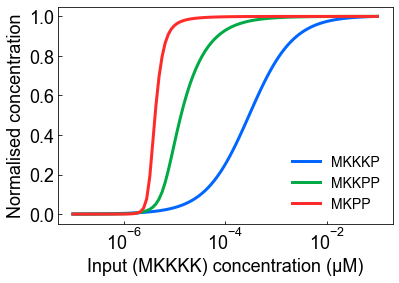

In [12]:
def plot_ss_response(input_concentrations,series1,series2=None):
    fig = plt.figure()
    (MKKKP,MKKPP,MKPP) = series1
    
    plt.plot(input_concentrations,np.array(MKKKP)/max(MKKKP),label="MKKKP",color="C0")
    plt.plot(input_concentrations,np.array(MKKPP)/max(MKKPP),label="MKKPP",color="C1")
    plt.plot(input_concentrations,np.array(MKPP)/max(MKPP),label="MKPP",color="C2")
    
    # Plot a second series if comparison is required
    if series2:
        (MKKKP2,MKKPP2,MKPP2) = series2
        plt.plot(input_concentrations,np.array(MKKKP2)/max(MKKKP),"--",color="C0")
        plt.plot(input_concentrations,np.array(MKKPP2)/max(MKKPP),"--",color="C1")
        plt.plot(input_concentrations,np.array(MKPP2)/max(MKPP),"--",color="C2")
        
    plt.xscale("log")
    plt.legend()
    plt.xlabel("Input (MKKKK) concentration (μM)")
    plt.ylabel("Normalised concentration")
    
    return fig

fig_ultrasensitivity = plot_ss_response(input_concentrations,(MKKKP,MKKPP,MKPP))

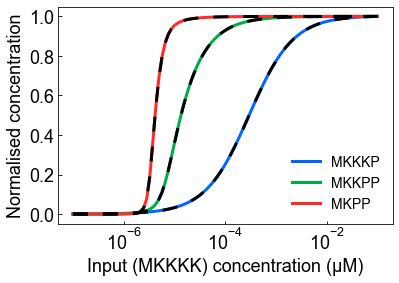

In [13]:
from Huang_Ferrell_MAPK import generate_activation_curve
(E1_vals,HK,_) = generate_activation_curve()

fig_act_comparison = plot_ss_response(input_concentrations,(MKKKP,MKKPP,MKPP))
plt.plot(E1_vals,HK[0]/max(HK[0]),c='black',linestyle=(0,(5,5)))
plt.plot(E1_vals,HK[1]/max(HK[1]),c='black',linestyle=(0,(5,5)))
plt.plot(E1_vals,HK[2]/max(HK[2]),c='black',linestyle=(0,(5,5)))

If the same simulations are run with reduced energy provided from ATP hydrolysis:
- The amount of input required to activate each enzyme is increased. The effect is more prominent for kinases later in the cascade due to the effects of amplification. As a result, the curve for MAPKPP shifts to be almost on top of MAPKKKP.
- However, the ultrasensitivity of the system appears to be preserved.

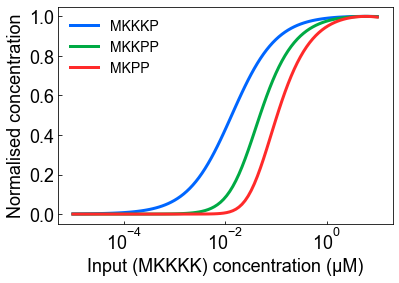

In [14]:
R = 8.314
T = 310
RT = R*T
(model/"SS:ATP").set_param("e",affinity_ATP_hydrolysis * 0.8)
#(model/"SS:ADP").set_param("e",5.0 * 0.8)
#(model/"SS:P").set_param("e",-5.0 * 0.8)
model.update_constitutive_relations()

input_concentrations = np.logspace(-5,1,num=100)

initial_conditions = {
    "MKKK": 0.003,
    "MKK": 1.2,
    "MK": 1.2,
    "MAPKKK-Pase": 0.0003,
    "MAPKK-Pase": 0.0003,
    "MAPK-Pase": 0.12
}

series_lowE = simulate_ss_response(model,input_concentrations,initial_conditions)
fig_reduced_energy = plot_ss_response(input_concentrations,series_lowE)

## Positive feedback

The MAPK cascade is regulated by a number of feedback loops. The true mechanisms of feedback are generally poorly understood and operate on components not included in our model of the cascade. Thus, we opt to represent feedback loops with phosphorylation cyles due to their simplicity. This also carries the advantage of allowing us to reuse the module defined earlier in the notebook (although it is also possible to define more detailed mechanisms if necessary).

In the code below, we define a module for positive feedback and add it to the model of the MAPK cascade.

In [15]:
class PositiveFeedback(PhosphorylationCycle):    
    @property
    def default_params(self):
        params = super().default_params
        
        phosphatase = self.phosphatase
        params[("Phosphatase/R:r1","r")] = 10*phosphatase.default_params[("R:r1","r")]
        params[("Phosphatase/R:r2","r")] = 10*phosphatase.default_params[("R:r2","r")]
        
        return params
        
class MAPK_PositiveFeedback(MAPK):
    def __init__(self,name="MAPK"):
        MAPK.__init__(self,name)
        
        a = 1000
        d = 150
        k = 150
        D = (a*k/d)**2*np.exp(-affinity_ATP_hydrolysis)
        P_factor = (np.sqrt(D)/k)*(d/a)*np.exp(affinity_ATP_hydrolysis)
        K_MKKKK = self.default_affinities["MKKKK"]
        K_MKKKKI = K_MKKKK/P_factor
        self.K_MKKKKI = K_MKKKKI
        
        feedback_phosphatase = Ce(name="MKKKK-Pase")
        inactive_MKKKK = Ce(name="MKKKK-I")
        K_MKPP = self.default_affinities["MKPP"]
        feedback = PositiveFeedback(
            name="Feedback",
            K_M = K_MKKKKI, K_MP = K_MKKKK, K_Kin = K_MKPP
        )
        self.feedback = feedback
        bgt.add(self,feedback,feedback_phosphatase,inactive_MKKKK)
        
        bgt.connect((feedback,"Kin"),self/"0:MKPP")
        bgt.connect((feedback,"Pho"),feedback_phosphatase)
        bgt.connect((feedback,"M"),inactive_MKKKK)
        bgt.connect((feedback,"MP"),self/"0:MKKKK")
        bgt.connect((feedback,"ATP"),self/"0:ATP")
        bgt.connect((feedback,"ADP"),self/"0:ADP")
        bgt.connect((feedback,"P"),self/"0:P")
        
        bgex.set_aqueous_solution_parameters(self,R=1.0,T=1.0)
    
    @property
    def default_params(self):
        params = super().default_params
        params[("C:MKKKK-Pase","k")] = 1.0
        params[("MKKKK-I","k")] = self.K_MKKKKI
        return params
        
    def set_params(self,params=None):
        MAPK.set_params(self)
        self.feedback.set_params()
        
        if not params:
            params = self.default_params
        bgex.set_parameters(self,params)

# A static version of the model
class MAPK_PositiveFeedback_Static(bgex.StaticBondGraph,MAPK_PositiveFeedback):
    def __init__(self,name="MAPK"):
        MAPK_PositiveFeedback.__init__(self,name)

A simulation of the resulting model is plotted below.

(<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>)

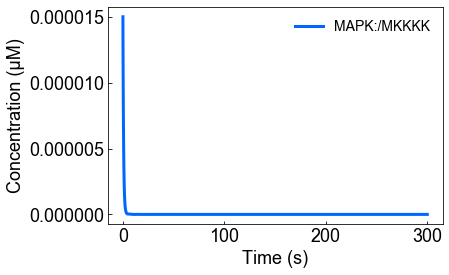

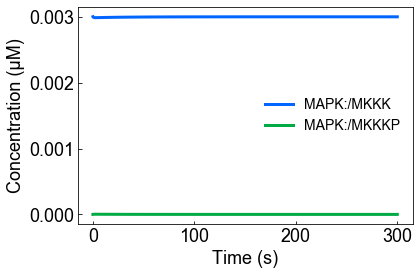

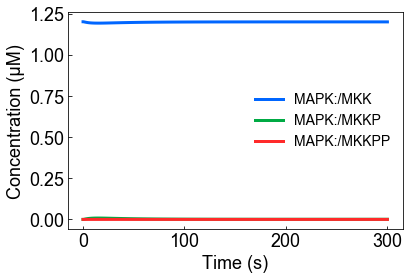

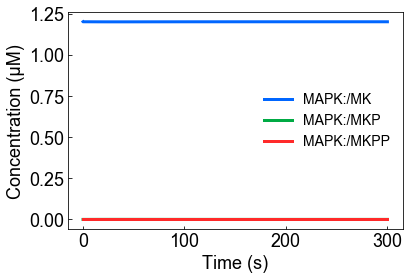

In [16]:
model = MAPK_PositiveFeedback()
model.set_params()

initial_conditions = {
    "MKKKK": 1.5e-5,
    "MKKKK-I": 1.5e-5,
    "MKKK": 0.003,
    "MKK": 1.2,
    "MK": 1.2,
    "MAPKKK-Pase": 0.0003,
    "MAPKK-Pase": 0.0003,
    "MAPK-Pase": 0.12,
    "MKKKK-Pase": 0.0003
}

sol = simulate(model,(0.0,300.0),MAPK_ic(model,initial_conditions),abstol=1e-7)
plot_kinases(sol,model)

Adding positive feedback to the MAPK cascade has been noted to lead to bistability. We test this in the code below by running the system to steady state for varying input concentrations. We also run two batches of simulations: one with the system initialised to an active state and one with the system initialised to an inactive state. The simulations confirm that a region where the cascade is bistabl

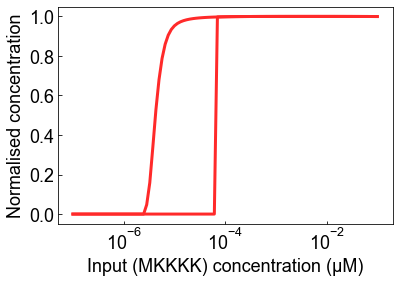

In [17]:
model = MAPK_PositiveFeedback_Static()
model.set_params()
model.update_constitutive_relations()

input_concentrations = np.logspace(-7,-1,num=100)

initial_conditions = {
    "MKKK": 0.003,
    "MKK": 1.2,
    "MK": 1.2,
    "MAPKKK-Pase": 0.0003,
    "MAPKK-Pase": 0.0003,
    "MAPK-Pase": 0.12,
    "MKKKK-Pase": 0.0003
}

series_pf = simulate_ss_response(model,input_concentrations,initial_conditions)

initial_conditions = {
    "MKKKP": 0.003,
    "MKKPP": 1.2,
    "MKPP": 1.2,
    "MAPKKK-Pase": 0.0003,
    "MAPKK-Pase": 0.0003,
    "MAPK-Pase": 0.12,
    "MKKKK-Pase": 0.0003
}

series_pf_on = simulate_ss_response(model,input_concentrations,initial_conditions)

fig_positive_feedback = plt.figure()
MKPP1 = series_pf[2]
MKPP2 = series_pf_on[2]

plt.plot(input_concentrations,np.array(MKPP1)/max(MKPP1),color="C2")
plt.plot(input_concentrations,np.array(MKPP2)/max(MKPP2),color="C2")
plt.xscale("log")
plt.xlabel("Input (MKKKK) concentration (μM)")
plt.ylabel("Normalised concentration")
plt.show()

## Negative feedback

In a similar manner, we define a negative feedback loop in the code below.

In [18]:
class NegativeFeedback(PhosphorylationCycle):       
    @property
    def default_params(self):
        phosphatase = self.phosphatase
        kinase = self.kinase
        
        params = super().default_params
        params[("Phosphatase/R:r1","r")] = 10*phosphatase.default_params[("R:r1","r")]
        params[("Phosphatase/R:r2","r")] = 10*phosphatase.default_params[("R:r2","r")]
        return params
        
class MAPK_NegativeFeedback(MAPK):
    def __init__(self,name="MAPK"):
        MAPK.__init__(self,name)
        
        a = 1000
        d = 150
        k = 150
        D = (a*k/d)**2*np.exp(-affinity_ATP_hydrolysis)
        P_factor = (np.sqrt(D)/k)*(d/a)*np.exp(affinity_ATP_hydrolysis)
        K_MKKKK = self.default_affinities["MKKKK"]
        K_MKKKKI = K_MKKKK*P_factor
        self.K_MKKKKI = K_MKKKKI
        
        K_MKPP = self.default_affinities["MKPP"]
        feedback = NegativeFeedback(
            name="Feedback",
            K_M = K_MKKKK, K_MP = K_MKKKKI, K_Kin = K_MKPP
        )
        self.feedback = feedback
        feedback_phosphatase = Ce(name="MKKKK-Pase")
        inactive_MKKKK = Ce(name="MKKKK-I")
        bgt.add(self,feedback,feedback_phosphatase,inactive_MKKKK)
        
        bgt.connect((feedback,"Kin"),self/"0:MKPP")
        bgt.connect((feedback,"Pho"),feedback_phosphatase)
        bgt.connect((feedback,"M"),self/"0:MKKKK")
        bgt.connect((feedback,"MP"),inactive_MKKKK)
        bgt.connect((feedback,"ATP"),self/"0:ATP")
        bgt.connect((feedback,"ADP"),self/"0:ADP")
        bgt.connect((feedback,"P"),self/"0:P")
        
        bgex.set_aqueous_solution_parameters(self,R=1.0,T=1.0)
    
    @property
    def default_params(self):
        params = super().default_params
        params[("C:MKKKK-Pase","k")] = 1.0
        params[("MKKKK-I","k")] = self.K_MKKKKI
        return params
        
    def set_params(self,params=None):
        MAPK.set_params(self)
        self.feedback.set_params()
        
        if not params:
            params = self.default_params
        bgex.set_parameters(self,params)
        
class MAPK_NegativeFeedback_Static(bgex.StaticBondGraph,MAPK_NegativeFeedback):
    def __init__(self,name="MAPK"):
        MAPK_NegativeFeedback.__init__(self,name)

A simulation of the model is run below. Note that the negative feedback results in some oscillatory behaviour (which has been known to occur in systems with negative feedback), although the oscillations dampen after a few cycles.

(<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>)

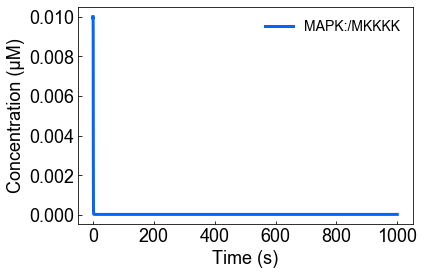

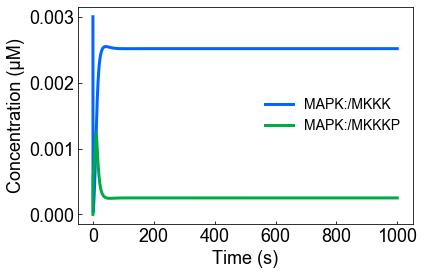

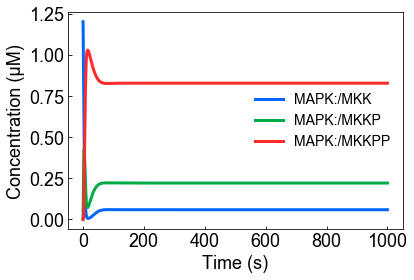

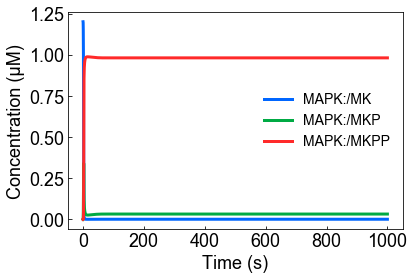

In [19]:
model = MAPK_NegativeFeedback()
model.set_params()

initial_conditions = {
    "MKKKK": 1e-2,
    "MKKK": 0.003,
    "MKK": 1.2,
    "MK": 1.2,
    "MAPKKK-Pase": 0.0003,
    "MAPKK-Pase": 0.0003,
    "MAPK-Pase": 0.12,
    "MKKKK-Pase": 0.0003
}

sol = simulate(model,(0.0,1000.0),MAPK_ic(model,initial_conditions),abstol=1e-7)
plot_kinases(sol,model)

Below, the steady-state response of the input is plotted. Due to the negative feedback, the transition between the inactive and active states of the output is more gradual compared to the system without feedback.

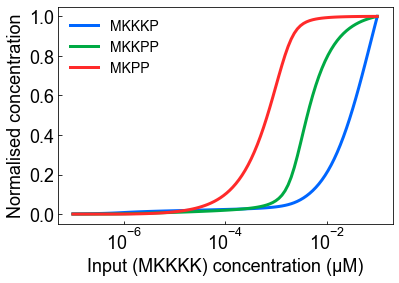

In [20]:
model = MAPK_NegativeFeedback_Static()
model.set_params()
model.update_constitutive_relations()

input_concentrations = np.logspace(-7,-1,num=100)

initial_conditions = {
    "MKKK": 0.003,
    "MKK": 1.2,
    "MK": 1.2,
    "MAPKKK-Pase": 0.0003,
    "MAPKK-Pase": 0.0003,
    "MAPK-Pase": 0.12,
    "MKKKK-Pase": 0.0003
}

series_nf = simulate_ss_response(model,input_concentrations,initial_conditions)
fig_negative_feedback = plot_ss_response(input_concentrations,series_nf)

Text(0.5,0,'Input (MKKKK) concentration (μM)')

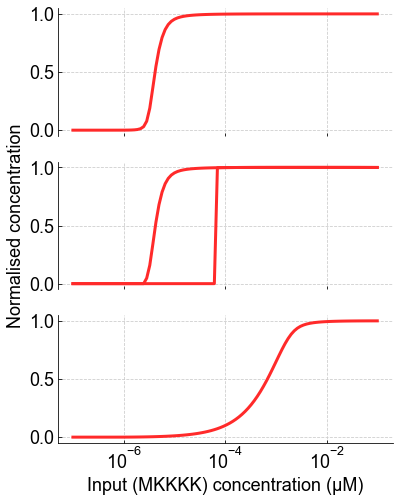

In [21]:
def normalise(A):
    return A/max(A)

fig_feedback, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(6,8))

ax1 = plt.subplot(311)
plt.plot(input_concentrations,normalise(series[2]),color='C2')
plt.xscale("log")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.grid(color='0.8', linestyle="--")

ax2 = plt.subplot(312)
plt.plot(input_concentrations,normalise(series_pf[2]),color='C2')
plt.plot(input_concentrations,normalise(series_pf_on[2]),color='C2')
plt.xscale("log")
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.grid(color='0.8', linestyle="--")
plt.ylabel("Normalised concentration")

ax3 = plt.subplot(313)
plt.plot(input_concentrations,normalise(series_nf[2]),color='C2')
plt.xscale("log")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
plt.grid(color='0.8', linestyle="--")
plt.xlabel("Input (MKKKK) concentration (μM)")

Text(0.5,0,'Input (MKKKK) concentration (μM)')

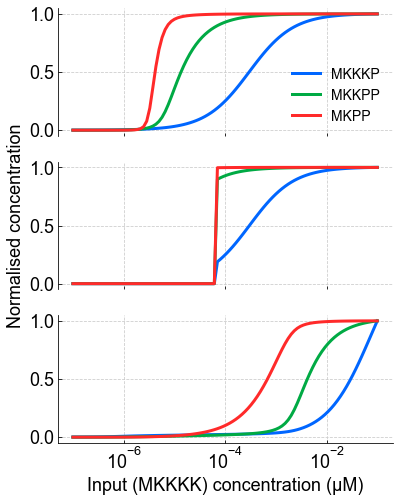

In [22]:
def normalise(A):
    return A/max(A)

def plot_ss_curves(input_concentrations,series):
    for i in range(3):
        plt.plot(input_concentrations, normalise(series[i]))
        plt.xscale("log")

fig_feedback2, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(6,8))

ax1 = plt.subplot(311)
plot_ss_curves(input_concentrations,series)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.grid(color='0.8', linestyle="--")
plt.legend(["MKKKP","MKKPP","MKPP"])

ax2 = plt.subplot(312)
plot_ss_curves(input_concentrations,series_pf)
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.grid(color='0.8', linestyle="--")
plt.ylabel("Normalised concentration")

ax3 = plt.subplot(313)
plot_ss_curves(input_concentrations,series_nf)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
plt.grid(color='0.8', linestyle="--")
plt.xlabel("Input (MKKKK) concentration (μM)")

In [23]:
save_figures = True
if save_figures:
    save_figure(fig_activation,"output/activation")
    save_figure(fig_ultrasensitivity,"output/ultrasensitivity")
    save_figure(fig_act_comparison,"output/MAPK_comparison_to_Huang_Ferrell")
    save_figure(fig_reduced_energy,"output/reduced_hydrolysis_energy")
    save_figure(fig_positive_feedback,"output/positive_feedback")
    save_figure(fig_negative_feedback,"output/negative_feedback")
    save_figure(fig_feedback,"output/feedback_comparison")
    save_figure(fig_feedback,"output/feedback_comparison2")